In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Dropout,Flatten,Input,Conv2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import  metrics
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
#loading the images
train_data = "C:/Users/megal/Downloads/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/train"
test_data = "C:/Users/megal/Downloads/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/test"
val_data = "C:/Users/megal/Downloads/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/val"

In [5]:
#seting Imagedata generator for data argumentation and rescaling
train = ImageDataGenerator(
    rescale = 1./255, #rescale pixel values to [0,1]
    rotation_range = 30, #randomly rotate images
    width_shift_range = 0.2,  #shift image horizontally
    height_shift_range = 0.2,  #shift image vertically
    shear_range = 0.2, #shear image 
    zoom_range = 0.2,  #zooming in or out
    horizontal_flip = True,  #randomaly flip images horizontally
    fill_mode = 'nearest'   #filling any missing pixels after transformations
)

In [6]:
#creating a generator for the training data
train_generators = train.flow_from_directory(
    train_data,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical' 
)

Found 6225 images belonging to 11 classes.


In [7]:
#creating an generator for testing data
test_generators = train.flow_from_directory(
    test_data,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 3187 images belonging to 11 classes.


In [8]:
val_generators = train.flow_from_directory(
    val_data,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 1092 images belonging to 11 classes.


In [5]:
#checking the class labels
print(f'class labels : {train_generators.class_indices}')

class labels : {'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}


In [9]:
#building cnn model
model = Sequential([
    #convolutional layer + pooling layer
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = (150,150,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128,(3,3),activation = 'relu'),
    layers.MaxPooling2D(2,2),

    #flatten the 3D tensor into 1D
    layers.Flatten(),

    #fully connected (Dense) layer
    layers.Dense(128,activation = 'relu'),

    #output layer
    layers.Dense(11,activation = 'softmax')
])

In [10]:
#compiling the model
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',  
    metrics = ['accuracy','precision','recall','f1_score']
)

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,771 (18.42 MB)

 Trainable params: 4,829,771 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
#training the model with early stopping
early_stopping = EarlyStopping(monitor = 'val_loss',patience = 3, restore_best_weights= True)


#fitting the model
history_cnn = model.fit(
    train_generators,
    epochs = 10,
    validation_data = val_generators,
    verbose = 2
)

Epoch 1/10
195/195 - 85s - 438ms/step - accuracy: 0.3235 - f1_score: 0.2229 - loss: 1.8902 - precision: 0.8529 - recall: 0.1332 - val_accuracy: 0.3828 - val_f1_score: 0.2802 - val_loss: 1.6581 - val_precision: 0.7702 - val_recall: 0.1749
Epoch 2/10
195/195 - 83s - 424ms/step - accuracy: 0.5390 - f1_score: 0.4408 - loss: 1.2804 - precision: 0.7951 - recall: 0.3222 - val_accuracy: 0.6310 - val_f1_score: 0.5232 - val_loss: 1.1046 - val_precision: 0.7547 - val_recall: 0.4734
Epoch 3/10
195/195 - 138s - 707ms/step - accuracy: 0.6851 - f1_score: 0.6008 - loss: 0.8892 - precision: 0.8038 - recall: 0.5508 - val_accuracy: 0.6914 - val_f1_score: 0.5980 - val_loss: 0.8667 - val_precision: 0.7881 - val_recall: 0.5687
Epoch 4/10
195/195 - 110s - 563ms/step - accuracy: 0.7550 - f1_score: 0.6720 - loss: 0.6669 - precision: 0.8369 - recall: 0.6778 - val_accuracy: 0.7930 - val_f1_score: 0.7251 - val_loss: 0.5911 - val_precision: 0.8464 - val_recall: 0.7317
Epoch 5/10
195/195 - 91s - 467ms/step - accura

Text(0.5, 1.0, 'Accuracy')

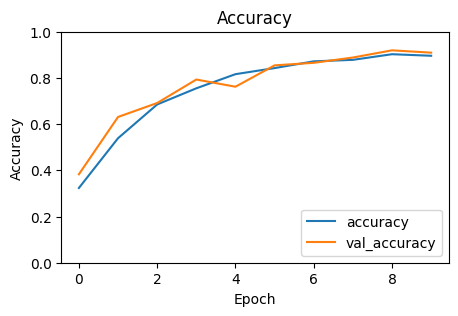

In [27]:
#plot the training and validation accuracy and loss
plt.figure(figsize = (5,3))

#accuracy  plot
plt.plot(history_cnn.history['accuracy'],label = 'accuracy')
plt.plot(history_cnn.history['val_accuracy'],label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc = 'lower right')
plt.title('Accuracy')



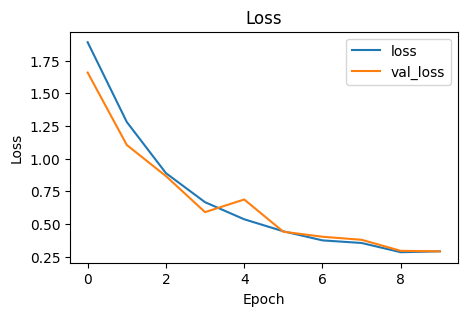

In [25]:
plt.figure(figsize = (5,3))
plt.plot(history_cnn.history['loss'],label = 'loss')
plt.plot(history_cnn.history['val_loss'],label = 'val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.show(7)

In [111]:
#saving the model
with open('cnn_model1.pkl','wb') as file:
    pickle.dump(model,file)

In [113]:
with open('cnn_model1.pkl','rb') as file:
    loading = pickle.load(file)

predicted = loading.predict(test_generators)

100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step


In [118]:
#evaluate the model
test_loss,test_acc,tes_f1score,test_pre,test_recall = loading.evaluate(test_generators,verbose = 2)

100/100 - 18s - 176ms/step - accuracy: 0.9583 - f1_score: 0.8729 - loss: 0.1362 - precision: 0.9612 - recall: 0.9554


In [ ]:
#evaluate the model
test_loss,test_acc,tes_f1score,test_pre,test_recall = model.evaluate(test_generators,verbose = 2)
print(f"Test accuracy : {test_acc :.4f},Loss : {test_loss : .4f}")

100/100 - 58s - 575ms/step - accuracy: 0.9416 - f1_score: 0.8843 - loss: 0.1704 - precision: 0.9511 - recall: 0.9332
Test accuracy : 0.9416,Loss :  0.1704


In [ ]:
#loading the VGG16 model with  neural network and without the last fully connected layers
base_model = VGG16(weights = 'imagenet',include_top = False,input_shape = (224,224,3))

In [59]:
#freeze the base model layers
base_model.trainable = False

In [60]:
#adding custom layers
inputs = Input(shape = (224,224,3))
x = base_model(inputs,training = False)
x = Flatten()(x)
x = Dense(256,activation = 'relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(11,activation = 'softmax')(x)

In [61]:
#model 
model = Model(inputs,outputs)

In [62]:
#compiling the model
model.compile(optimizer = SGD(learning_rate = 0.01),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy','recall','precision','f1_score']
)

In [32]:
#model summary
model.summary()

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,140,299 (80.64 MB)

 Trainable params: 6,425,611 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [19]:
#creating a generator for the training data
train_generators = train.flow_from_directory(
    train_data,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical' 
)

Found 6225 images belonging to 11 classes.


In [20]:
test_generators = train.flow_from_directory(
    test_data,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 3187 images belonging to 11 classes.


In [21]:
val_generators = train.flow_from_directory(
    val_data,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 1092 images belonging to 11 classes.


In [67]:
#fitting the model
history_vgg = model.fit(
    train_generators,
    epochs = 10,
    batch_size = 32,
    validation_data = val_generators
)

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 1301s 7s/step - accuracy: 0.1800 - f1_score: 0.0794 - loss: 2.2751 - precision: 0.7590 - recall: 0.0176 - val_accuracy: 0.1712 - val_f1_score: 0.0266 - val_loss: 2.1978 - val_precision: 0.6479 - val_recall: 0.1685
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 1362s 7s/step - accuracy: 0.2173 - f1_score: 0.1074 - loss: 2.1246 - precision: 0.8418 - recall: 0.0912 - val_accuracy: 0.3123 - val_f1_score: 0.1608 - val_loss: 1.9077 - val_precision: 0.9415 - val_recall: 0.1621
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 1342s 7s/step - accuracy: 0.2629 - f1_score: 0.1553 - loss: 1.9863 - precision: 0.9011 - recall: 0.1215 - val_accuracy: 0.3663 - val_f1_score: 0.2050 - val_loss: 1.7879 - val_precision: 0.9010 - val_recall: 0.1667
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 1184s 6s/step - accuracy: 0.2875 - f1_score: 0.1781 - loss: 1.8833 - precision: 0.9141 - recall: 0.1374 - val_accuracy: 0.4496 - val_f1_score: 0.2822 - val_loss: 1.6076 - val_precision: 0.9457 - val

In [75]:
with open('vgg_model1.pkl','wb') as file:
    pickle.dump(model,file)

In [23]:
with open('vgg_model1.pkl','rb') as file:
    trained_model = pickle.load(file)

#pred = trained_model.predict(test_generators)


In [24]:
#evaluate the model
test_loss,test_acc,tes_f1score,test_pre,test_recall = trained_model.evaluate(test_generators,verbose = 2)

100/100 - 676s - 7s/step - accuracy: 0.5293 - f1_score: 0.4284 - loss: 1.4080 - precision: 0.9745 - recall: 0.2040


In [28]:
# Create the ResNet50 model
resnet_model = Sequential()
resnet = tf.keras.applications.ResNet50(include_top=False,
                                        input_shape=(224, 224, 3),
                                        pooling='avg',
                                        weights='imagenet')
                                        
                                                  

In [29]:
# Freeze the layers of the pretrained model
for layer in resnet.layers:
    layer.trainable = False

resnet_model.add(resnet)

In [30]:
# Add custom layers for classification
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dense(11, activation='softmax'))

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate =0.001), loss='categorical_crossentropy', metrics=['accuracy','recall','precision','f1_score'])

In [31]:
#training the model with early stopping
early_stopping = EarlyStopping(monitor = 'val_loss',patience = 3, restore_best_weights= True)

history_resnet = resnet_model.fit(train_generators, validation_data=val_generators, epochs=10)

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 493s 3s/step - accuracy: 0.1697 - f1_score: 0.1099 - loss: 2.3388 - precision: 0.7842 - recall: 0.0133 - val_accuracy: 0.1804 - val_f1_score: 0.0582 - val_loss: 2.2201 - val_precision: 0.7857 - val_recall: 0.0705
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - accuracy: 0.2296 - f1_score: 0.1492 - loss: 2.1359 - precision: 0.9063 - recall: 0.0579 - val_accuracy: 0.2189 - val_f1_score: 0.1046 - val_loss: 2.1264 - val_precision: 0.9231 - val_recall: 0.0440
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 451s 2s/step - accuracy: 0.2490 - f1_score: 0.1689 - loss: 2.0745 - precision: 0.9141 - recall: 0.0598 - val_accuracy: 0.2097 - val_f1_score: 0.1083 - val_loss: 2.0868 - val_precision: 0.7034 - val_recall: 0.0934
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.2592 - f1_score: 0.1769 - loss: 2.0347 - precision: 0.8265 - recall: 0.0651 - val_accuracy: 0.2756 - val_f1_score: 0.1797 - val_loss: 2.0366 - val_precision: 0.9143 - val_rec

Text(0.5, 1.0, 'Accuracy')

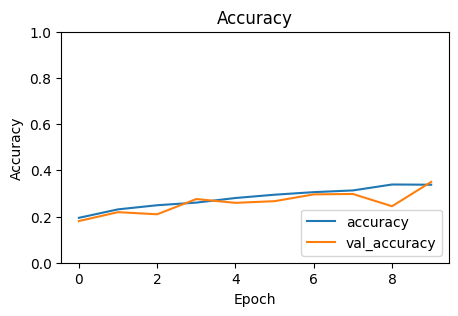

In [32]:
#plot the training and validation accuracy and loss
plt.figure(figsize = (5,3))

#accuracy  plot
plt.plot(history_resnet.history['accuracy'],label = 'accuracy')
plt.plot(history_resnet.history['val_accuracy'],label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc = 'lower right')
plt.title('Accuracy')

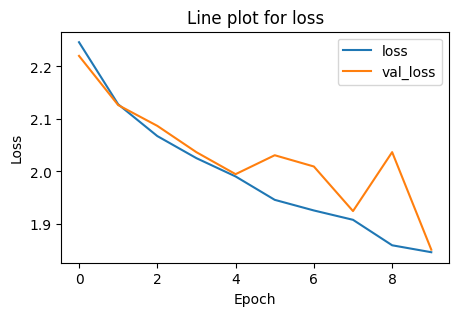

In [57]:
#loss plot
plt.figure(figsize = (5,3))
plt.plot(history_resnet.history['loss'],label = 'loss')
plt.plot(history_resnet.history['val_loss'],label = 'val_loss')
plt.title('Line plot for loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show(7)

In [136]:
with open('resnet.pkl','wb') as file:
    pickle.dump(resnet_model,file)

In [139]:
with open('resnet.pkl','rb') as file:
    resnets = pickle.load(file)

#predictors = resnets.predict(test_generators)

In [141]:
resnet_test = resnets.evaluate(test_generators,verbose = 2)

100/100 - 190s - 2s/step - accuracy: 0.3163 - f1_score: 0.2129 - loss: 1.8674 - precision: 0.8368 - recall: 0.0756


In [34]:
#loading the mobilenet without top layers
mobile_model = MobileNet(weights = 'imagenet',include_top = False,input_shape = (224,224,3))

#freezeing the model layers
mobile_model.trainable = False

In [35]:
#adding custom layers
x = mobile_model.output
x = GlobalAveragePooling2D()(x) #global average pooling layer
x = Dense(128,activation = 'relu')(x)  #fully connected layer
output = Dense(11,activation = 'softmax')(x) #output layer

In [36]:
model_mn = Model(inputs = mobile_model.input,outputs = output)

In [37]:
#compile the model
model_mn.compile(optimizer = 'adam',
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy','recall','precision','f1_score']
                 )

In [38]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model_mn.fit(
    train_generators,
    validation_data=val_generators,
    epochs=10,
    batch_size = 32
)

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 117s 588ms/step - accuracy: 0.7484 - f1_score: 0.6617 - loss: 0.7825 - precision: 0.9150 - recall: 0.6341 - val_accuracy: 0.9533 - val_f1_score: 0.8862 - val_loss: 0.1358 - val_precision: 0.9610 - val_recall: 0.9469
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 158s 811ms/step - accuracy: 0.9735 - f1_score: 0.9345 - loss: 0.0871 - precision: 0.9795 - recall: 0.9691 - val_accuracy: 0.9597 - val_f1_score: 0.9156 - val_loss: 0.1057 - val_precision: 0.9640 - val_recall: 0.9551
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 165s 847ms/step - accuracy: 0.9810 - f1_score: 0.9523 - loss: 0.0637 - precision: 0.9826 - recall: 0.9782 - val_accuracy: 0.9634 - val_f1_score: 0.9080 - val_loss: 0.1139 - val_precision: 0.9650 - val_recall: 0.9606
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9838 - f1_score: 0.9656 - loss: 0.0505 - precision: 0.9855 - recall: 0.9820 - val_accuracy: 0.9734 - val_f1_score: 0.9186 - val_loss: 0.0803 - val_precision: 0.9752 

In [ ]:
#accuracy  plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label = 'accuracy')
plt.plot(history.history['val_accuracy'],label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0,1])
plt.legend(loc = 'lower right')
plt.title('Accuracy')

Text(0.5, 1.0, 'Accuracy')

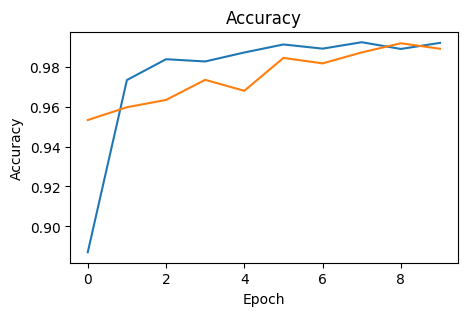

In [ ]:
plt.figure(figsize = (5,3))
plt.plot(history.history['accuracy'],label = 'accuracy')
plt.plot(history.history['val_accuracy'],label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

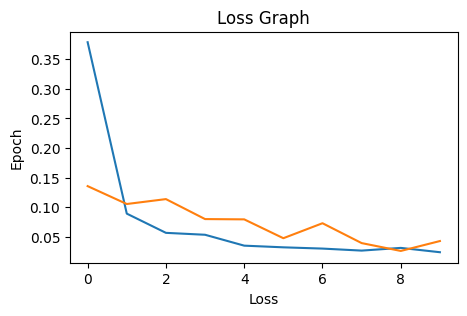

In [44]:
plt.figure(figsize = (5,3))
plt.plot(history.history['loss'],label ='loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.title('Loss Graph')
plt.legend
plt.show()

In [157]:
with open('mobile_model.pkl','wb') as file:
    pickle.dump(model_mn,file)

In [3]:
import pickle
with open('mobile_model.pkl','rb') as file:
    mn_trained = pickle.load(file)

In [160]:
mn = mn_trained.evaluate(test_generators)

100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 573ms/step - accuracy: 0.9850 - f1_score: 0.9337 - loss: 0.0452 - precision: 0.9860 - recall: 0.9841


In [45]:
# Load the InceptionV3 model without the top layers
inv3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [46]:
# Freeze the base model layers
inv3_model.trainable = False

In [47]:
# Add custom layers on top of the base model
x = inv3_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer
output = Dense(11, activation='softmax')(x)  # Output layer

# Create the complete model
model = Model(inputs=inv3_model.input, outputs=output)

In [48]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','recall','precision','f1_score'])

In [50]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history_inv3 = model.fit(
    train_generators,
    validation_data=val_generators,
    epochs=10,
    batch_size = 64
)

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.9516 - f1_score: 0.9301 - loss: 0.1296 - precision: 0.9561 - recall: 0.9491 - val_accuracy: 0.9551 - val_f1_score: 0.9004 - val_loss: 0.1596 - val_precision: 0.9548 - val_recall: 0.9487
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.9598 - f1_score: 0.9378 - loss: 0.1137 - precision: 0.9631 - recall: 0.9569 - val_accuracy: 0.9478 - val_f1_score: 0.8931 - val_loss: 0.1600 - val_precision: 0.9512 - val_recall: 0.9451
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.9504 - f1_score: 0.9049 - loss: 0.1396 - precision: 0.9544 - recall: 0.9473 - val_accuracy: 0.9496 - val_f1_score: 0.9052 - val_loss: 0.1483 - val_precision: 0.9529 - val_recall: 0.9451
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.9622 - f1_score: 0.9363 - loss: 0.1188 - precision: 0.9658 - recall: 0.9589 - val_accuracy: 0.9423 - val_f1_score: 0.8956 - val_loss: 0.1687 - val_precision: 0.9465 - val_rec

In [170]:
with open('inv3_model.pkl','wb') as file:
    pickle.dump(history_inv3,file)

In [ ]:
with open('inv3_model.pkl','rb') as file:
    inv3_trained = pickle.load(file)

inv3_test = inv3_trained.evaluate(test_generators)

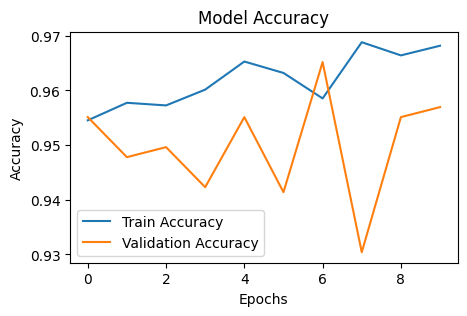

In [53]:
plt.figure(figsize = (5,3))
plt.plot(history_inv3.history['accuracy'], label='Train Accuracy')
plt.plot(history_inv3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


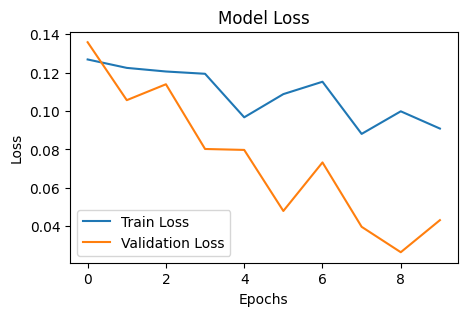

In [55]:
# Plot loss
plt.figure(figsize = (5,3))
plt.plot(history_inv3.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()